# 2D Acoustic Wave Propagation using Finite-Difference Time-Domain (FDTD) Method

## 2D Acoustic Wave And Discretization

### 1. Fundamental Wave Equation
The second-order acoustic wave equation being solved:

$$
\frac{\partial^2 p}{\partial t^2} = v_p^2 \left( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2} \right) + s(x,z,t)
$$

Where:
- $ p $   = pressure wavefield
- $ v_p $ = P-wave velocity (m/s)
- $ s $   = source term

---

### 2. Finite Difference Discretization

#### Time Derivative (Second Order)
$$
\frac{\partial^2 p}{\partial t^2} \approx \frac{p^{t+1}_{i,j} - 2p^t_{i,j} + p^{t-1}_{i,j}}{\Delta t^2}
$$

#### Spatial Derivatives (Central Differences)
##### X-direction:
$$
\frac{\partial^2 p}{\partial x^2} \approx \frac{p^t_{i,j+1} - 2p^t_{i,j} + p^t_{i,j-1}}{\Delta x^2}
$$

##### Z-direction:
$$
\frac{\partial^2 p}{\partial z^2} \approx \frac{p^t_{i+1,j} - 2p^t_{i,j} + p^t_{i-1,j}}{\Delta z^2}
$$

---

### 3. Update Equation
The leapfrog time-stepping scheme:

$$
p^{t+1}_{i,j} = 2p^t_{i,j} - p^{t-1}_{i,j} + v_p^2 \left[ \frac{\Delta t^2}{\Delta x^2}(p^t_{i,j+1} - 2p^t_{i,j} + p^t_{i,j-1}) + \frac{\Delta t^2}{\Delta z^2}(p^t_{i+1,j} - 2p^t_{i,j} + p^t_{i-1,j}) \right] + s^t_{i,j}\Delta t^2
$$

---

### 4. Source Term
Gaussian wavelet source implementation: (Ricker wavelet could also be use)

$$
s(t) = A \cdot \exp\left(-\pi^2 f_0^2 (t - t_0)^2\right)
$$

Parameters:
- $ A $   = amplitude
- $ f_0 $ = dominant frequency (Hz)
- $ t_0 $ = time delay (s)

---

### 5. Stability Condition
CFL stability criterion:

$$
\Delta t \leq \frac{C}{\max(v_p)} \left( \frac{1}{\Delta x^2} + \frac{1}{\Delta z^2} \right)^{-1/2}
$$

Where $ C $ is the Courant number.


In [22]:
#Dependecies

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import os
import time
from tqdm import tqdm # For progress bars


In [23]:
def plot(title,t,p,tlabel):
    plt.figure()
    plt.plot(t,p,'b-')
    plt.xlim(t[0], t[nt-1])
    plt.title(title,fontsize=18)
    plt.xlabel(tlabel, fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.grid()
    plt.show()

def make_source(p_source,T):
    a = 1.2/(T/4)**2
    t0 = np.sqrt(np.log(0.00001)/(-a))
    for it in range(nt):
        # p_source[it] = np.exp(-a*(it*dt-t0)**2)                  # Gaussian
        p_source[it] = -2*a*(it*dt-t0)*np.exp(-a*(it*dt-t0)**2)  # First derivative Gaussian
#         p_source[it] = (-2*a+(-2*a*(it*dt-t0))**2)*np.exp(-a*(it*dt-t0)**2)  # Second derivative Gaussian 

# Make a source wavelet with period ~ T = lambda/c_min
c_min  = 1500
dx, dz = 10.0, 10.0           # Grid size
gp_per_wavelength = 10        # Specify the number of gridpoints per wavelength
lamda = gp_per_wavelength*dx  # Wavelength in the model of gp_per_wavelength grid spacings
T     = lamda/c_min           # Fundamental period of the source
# f0 = 15; T = 1/15
f0    = 1/T
nt    = 1001
dt    = 1e-3

print("-----------------")
print("Source properties")
print("-----------------")
print("Fundamental wavelength at c = c_min = ",lamda," (mL)")
print("Fundamental period                  = %6.4f" %(T) ," (secs)")
print("Fundamental frequency               = ",f0," (Hz)")
print("-----------------")

p_source = np.zeros(nt)
make_source(p_source,T)
tt = np.linspace(0,(nt-1)*dt,num=nt)
df = 1/(nt*dt)
ff = np.linspace(0,(nt-1)*df,num=nt)
# plot("Source wavelet",tt,p_source,"Time (secs)")                  # Plot source wavelet
P_source = np.sqrt(fft(p_source).real**2 + fft(p_source).imag**2) # Plot source spectrum
# plot("Source spectrum",ff,P_source,"Frequency (Hz)")

p_source.shape


-----------------
Source properties
-----------------
Fundamental wavelength at c = c_min =  100.0  (mL)
Fundamental period                  = 0.0667  (secs)
Fundamental frequency               =  15.0  (Hz)
-----------------


(1001,)

(1001,)

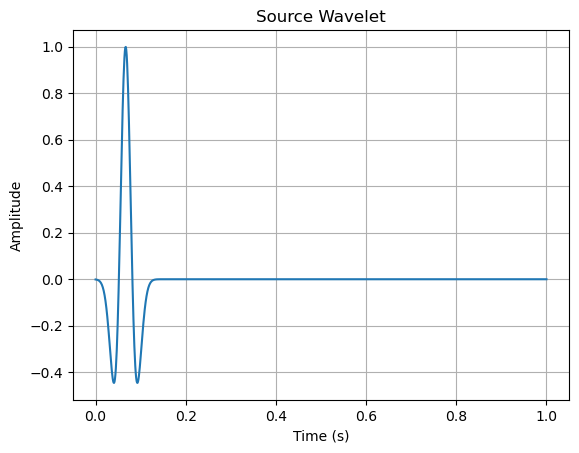

In [24]:
nt = 1000
dt = 1e-3
t  = np.arange(0, nt+1) * dt   # Time vector

# Source parameters
f0 = 15.0        # Dominant frequency [Hz]
t0 = 1. / f0     # Excitation time [sec]
# factor = 1e10   # Amplitude coefficient

a   = (np.pi * f0)**2

## --- Ricker (Mexican Hat) Wavelet ---
source_term = (1.0 - 2.0*a*(t - t0)**2) * np.exp(-a*(t - t0)**2) # Mexican Hat (Ricket Wavelet) - (second derivative of a Gaussian)

## source_term =  -2.0*a*(t - t0) * np.exp(-a*(t - t0)**2)         # First derivative of a Gaussian:
## source_term = np.exp(-a*(t-t0)**2)                  # Gaussian

#############################################################

## --- Gabor (Gaussian-Modulated Cosine) Wavelet ---
# source_term = np.exp(-((t - t0)**2) * a) * np.cos(2 * np.pi * f0 * (t - t0))

## --- Gaussian Pulse (Non-oscillatory, rare in seismic modeling) ---
# source_term = np.exp(-a * (t - t0)**2)

## --- Berlage Wavelet ---
# A = 1.0
# n = 2
# alpha = 20
# phi = 0  # phase in radians
# source_term = A * (t - t0)**n * np.exp(-alpha * (t - t0)) * np.cos(2 * np.pi * f0 * (t - t0) + phi)
# source_term[t < t0] = 0      # Causal cutoff

## --- Klauder Wavelet (via autocorrelation of linear chirp) ---
# from scipy.signal import chirp, correlate
# chirp_sig = chirp(t, f0=5, f1=50, t1=t[-1], method='linear')
# source_term = correlate(chirp_sig, chirp_sig, mode='same')
# source_term /= np.max(np.abs(source_term))  # Normalize

############################################################

plt.plot(t, source_term)
plt.title("Source Wavelet")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

source_term.shape


In [25]:
def generate_shot_gathers_acoustic_wave(velocity_models, dx=10.0, dz=10.0, num_receivers=70, num_shots=5):

    """
    This function generate synthetic shot gathers for multiple velocity models (500) with multiple shots (5)
    
    Parameters:
    velocity_models : numpy.ndarray
        Array of velocity models with shape (n_models, 1, nz, nx). 
        n_models is the number of velocity maps.
        nz and nx are the grid points in each velocity map
    dx, dz : float
        Grid spacing in meters
    num_receivers : int
        Number of receivers to place along the surface
    num_shots : int
        Number of shots to fire per velocity model
    
    Returns:
    numpy.ndarray (500,5,1000,70)
        Array of shot gathers with shape (n_models, num_shots, nt, num_receivers)
    """
    # ======================
    # SIMULATION PARAMETERS
    # ======================
    
    # Get model dimensions from input velocity model
    n_models, _, nz, nx = velocity_models.shape
    print(f"Processing {n_models} velocity models of size {nz}x{nx}")
    print(f"Generating {num_shots} shots per model with {num_receivers} receivers")
    
    # ======================
    # TIME STEPPING PARAMETERS
    # ======================
    t_max = 1.0                       # Total simulation time [sec]
    dt    = 1e-3                      # Time step
    nt    = int(round(t_max / dt))    # Number of time steps
    t     = np.arange(0, nt+1) * dt   # Time vector
    # t = np.linspace(0, t_max, nt+1) # Time vector

    # Source parameters
    f0     = 15.0       # Dominant frequency [Hz]
    t0     = 1.0 / f0   # Excitation time [sec]
    factor = 1e7        # Amplitude coefficient
    
    # ======================
    # SOURCE AND RECEIVERS
    # ======================
    # Source positions (x-coordinates in grid units: 0, 17.5, 35, 52.5, 70)
    # src_x     = np.linspace(0, nx-1, num_shots)
    src_x     = np.round(np.linspace(0, nx-1, num_shots)).astype(int)
    src_depth = 1  # Source depth index (near surface)

    # Receiver positions (along surface)
    g_depth = 1  # Receiver depth index (near surface)
    g_x     = np.linspace(0, nx-1, num_receivers, dtype=int)

    # Initialize array to store all shot gathers
    # shot_gathers = np.zeros((n_models, nt, num_receivers))

    # Initialize array to store all shot gathers
    shot_gathers = np.zeros((n_models, num_shots, nt, num_receivers))
    
    # ======================
    # MAIN PROCESSING LOOP
    # ======================
    # Start timer
    start_time = time.time()
    
    for model_idx in tqdm(range(n_models), desc="Forward modelling"):
        
        #Get current velocity model (remove singleton dimension)
        vp = velocity_models[model_idx, 0, :, :]
    
        # ======================
        # ABSORBING BOUNDARY (Cerjan, 1985)
        # ======================
    
        # Thickness of absorbing boundary layer (15% of model size)
        abs_thick = min(int(0.15 * nx), int(0.15 * nz))
        
        # Decay rate for sponge layer
        abs_rate = 0.3 / abs_thick
       
        # Define margins for left/right boundaries
        lmargin = [abs_thick, abs_thick]
        rmargin = [abs_thick, abs_thick]
    
        # Initialize weights for sponge layer (1 = no absorption)
        weights = np.ones((nz + 2, nx + 2))
        
        # Calculate weights for sponge layer (exponential decay)
        for iz in range(nz + 2):
            for ix in range(nx + 2):
                i = 0
                j = 0
                k = 0
                
                # Check left boundary in x-direction
                if ix < lmargin[0] + 1:
                    i = lmargin[0] + 1 - ix
                    
                # Check left boundary in z-direction
                if iz < lmargin[1] + 1:
                    k = lmargin[1] + 1 - iz
                
                # Check right boundary in x-direction
                if nx - rmargin[0] < ix:
                    i = ix - nx + rmargin[0]
                
                # Check right boundary in z-direction
                if nz - rmargin[1] < iz:
                    k = iz - nz + rmargin[1]
                
                # If in the absorbing layer, calculate weight
                if i != 0 or j != 0 or k != 0:
                    rr = abs_rate * abs_rate * float(i*i + j*j + k*k )
                    weights[iz, ix] = np.exp(-rr)
    
        # ======================
        # SHOT LOOP
        # ======================
        for shot_idx in range(num_shots):
            src = int(round(src_x[shot_idx]))
            
            # Initialize wavefields with boundary padding
            pnew = np.zeros((nz + 2, nx + 2))  # Pressure wavefield at time t + dt - # Current time step
            p    = np.zeros((nz + 2, nx + 2))  # Pressure wavefield at time t      - # Previous time step
            pold = np.zeros((nz + 2, nx + 2))  # Pressure wavefield at time t - dt - # Time step before previous
            
            # Coefficients for finite differences
            co_dxx = 1.0 / dx**2
            co_dzz = 1.0 / dz**2
        
            # Source time function (Ricker wavelet)
            a   = (np.pi * f0)**2
            dt2 = dt**2
            source_term = factor * (1.0 - 2.0*a*(t-t0)**2) * np.exp(-a*(t-t0)**2) # Mexican Hat (Ricket Wavelet)
#             source_term =  -2.0*a*(t-t0) * np.exp(-a*(t - t0)**2)         # First derivative of a Gaussian
            
            # Array to store wavefield snapshots - store receiver readings
            # wavefield_snapshots = np.zeros((nt, nz, nx))
            recorded_wavefield = np.zeros((nt, num_receivers)) # receiver_data 
            
            # ======================
            # TIME STEPPING LOOP
            # ======================
            for it in range(nt):
                # Reset current wavefield
                pnew.fill(0)
                
                # Calculate spatial derivatives - [1 -2 1] stencil
                # Calculate second-order spatial derivatives using finite differences
                dp_dxx = co_dxx * (p[1:-1, :-2] - 2 * p[1:-1, 1:-1] + p[1:-1, 2:])    # x-direction derivative: d^2p/dx^2
                dp_dzz = co_dzz * (p[:-2, 1:-1] - 2 * p[1:-1, 1:-1] + p[2:, 1:-1])    # z-direction derivative: d^2p/dz^2
                
                # Update wavefield
                pnew[1:-1, 1:-1] = (2.0 * p[1:-1, 1:-1] - pold[1:-1, 1:-1] + 
                                  (vp**2) * (dp_dxx + dp_dzz) * dt2)
                
                # Add source term at source location
                pnew[src_depth, src] += source_term[it] * dt2
                
                # Apply absorbing boundary conditions by multiplying with weights
                pold = p * weights
                p    = pnew * weights
                
                # Store wavefield snapshot (without boundaries)
                # recorded_wavefield[it] = pnew[1:-1, 1:-1]
                recorded_wavefield[it, :] = pnew[g_depth, g_x]  # g_x contains receiver indices
            
                # Or record receiver data
                # for rec_idx in range(num_receivers):
                #     rx = g_x[rec_idx]
                #     recorded_wavefield[it, rec_idx] = pnew[g_depth, rx]
                    
            # Store the shot gather for this model
            shot_gathers[model_idx, shot_idx, :, :] = recorded_wavefield
    
    # Print elapsed time
    elapsed_time = (time.time() - start_time)/60
    print(f'Elapsed time: {elapsed_time:.2f} minutes')
    
    return shot_gathers


In [26]:
if __name__ == "__main__":
    
    # synthetic velocity models - Shape: (500, 1, 70, 70)
    velocity_models = np.load('C:/Users/g202204900/OneDrive - KFUPM/Desktop/Kaggle Competition/OpenFWI/train_samples/FlatVel_A/model/model2.npy')
#     velocity_models = np.load('C:/Users/g202204900/OneDrive - KFUPM/Desktop/Kaggle Competition/OpenFWI/train_samples/FlatVel_A/model/model1.npy')
    
    # print('Velocity map size:', velocity_models.shape)
    
    # Generate shot gathers
    shot_gathers = generate_shot_gathers_acoustic_wave(velocity_models)
    
    # Save results (optional)
    np.save("synthetic_shot_gathers.npy", shot_gathers)


Processing 500 velocity models of size 70x70
Generating 5 shots per model with 70 receivers


Forward modelling: 100%|█████████████████████████████████████████████████████████████| 500/500 [03:31<00:00,  2.37it/s]


Elapsed time: 3.52 minutes


## Visualization

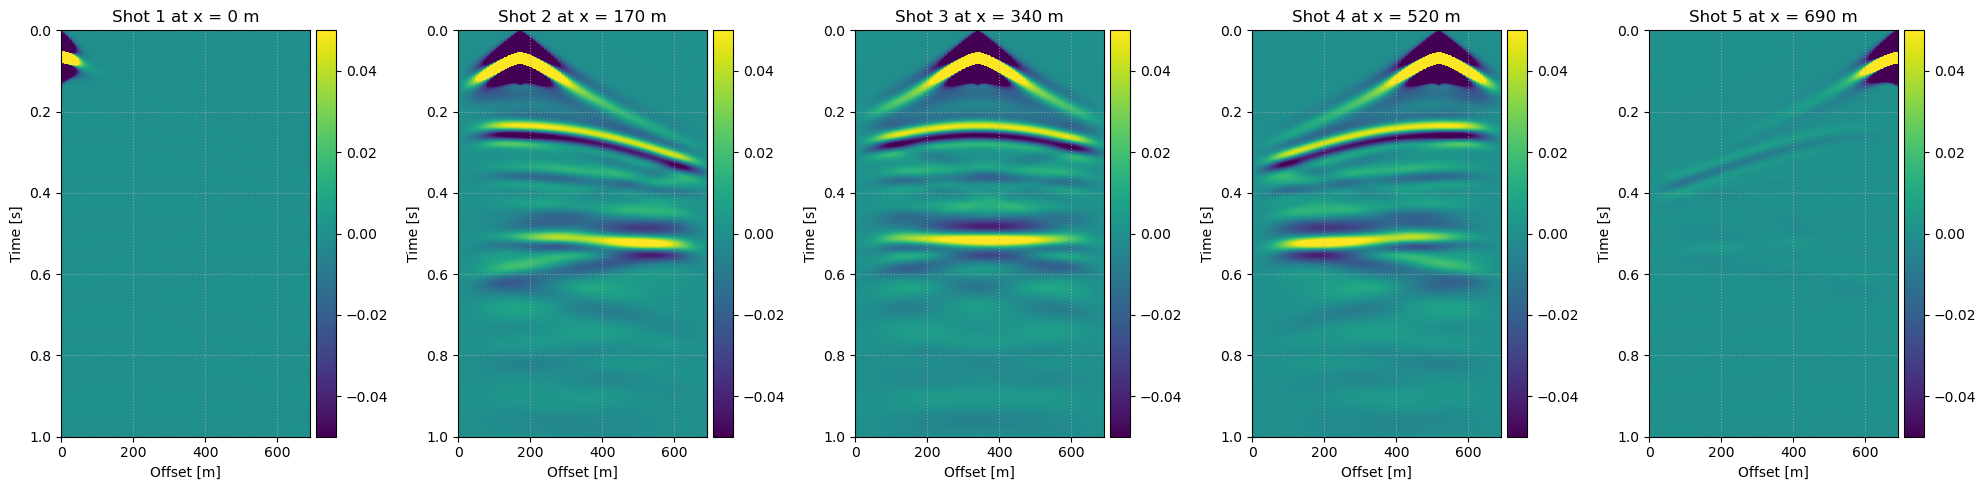

In [27]:

num_receivers = 70
t_max         = 1
nx, nz        = 70, 70
num_shots     = 5
src_x         = np.round(np.linspace(0, nx-1, num_shots)).astype(int)
# print(np.load("./synthetic_shot_gathers.npy").shape) # Shape of the recorded data

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    # Display shot gather with proper orientation
    img = axes[i].imshow(shot_gathers[14, i,:,:], 
                        aspect='auto',
                        extent=[0, (num_receivers-1)*10, t_max, 0],  # X: receivers, Y: time (0 at top)
                        cmap='viridis',
                        vmin=-0.05, 
                        vmax=0.05)
    
    # Add colorbar to the right of each plot
    cbar = plt.colorbar(img, ax=axes[i], pad=0.02)
    # cbar.set_label('Amplitude', rotation=270, labelpad=15)

    # Set labels and title
    axes[i].set_title(f'Shot {i+1} at x = {int(src_x[i]) * 10} m')
    axes[i].set_xlabel('Offset [m]')
    axes[i].set_ylabel('Time [s]')

    # Add grid lines for better readability
    axes[i].grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


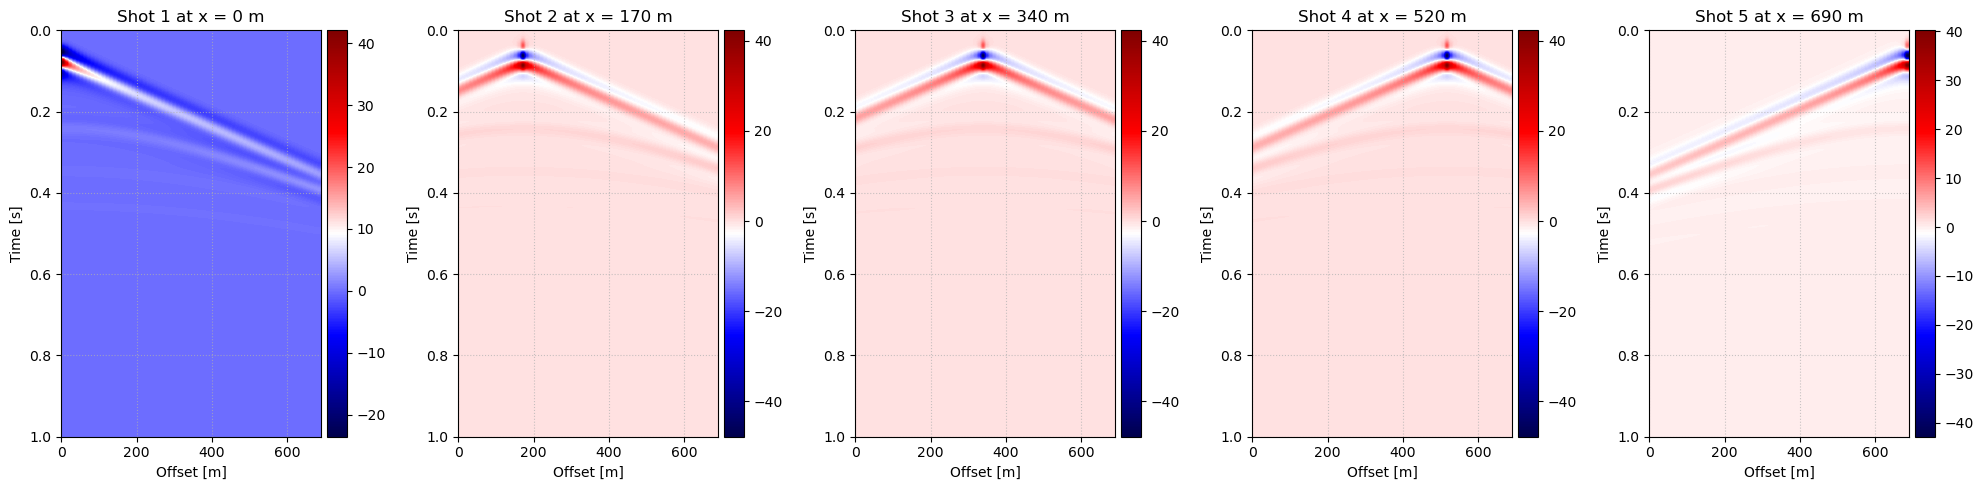

In [28]:
real_data = np.load('C:/Users/g202204900/OneDrive - KFUPM/Desktop/Kaggle Competition/OpenFWI/train_samples/FlatVel_A/data/data2.npy')
# real_data = np.load('C:/Users/g202204900/OneDrive - KFUPM/Desktop/Kaggle Competition/OpenFWI/train_samples/FlatVel_A/data/data1.npy')

syn_data = np.load("./synthetic_shot_gathers.npy")

diff = real_data - syn_data

# Visualization
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    # Display shot gather with proper orientation
    img = axes[i].imshow(diff[14, i,:,:], 
                        aspect='auto',
                        extent=[0, (num_receivers-1)*10, t_max, 0],  # X: receivers, Y: time (0 at top)
                        cmap='seismic')
                        # vmin=-1e-6, 
                        # vmax=1e-6)
    
    # Add colorbar to the right of each plot
    cbar = plt.colorbar(img, ax=axes[i], pad=0.02)
    # cbar.set_label('Amplitude', rotation=270, labelpad=15)

    # Set labels and title
    axes[i].set_title(f'Shot {i+1} at x = {int(src_x[i]) * 10} m')
    axes[i].set_xlabel('Offset [m]')
    axes[i].set_ylabel('Time [s]')

    # Add grid lines for better readability
    axes[i].grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


In [29]:
# shot_gathers = np.load("./synthetic_shot_gathers.npy").shape; print(shot_gathers) # Shape of the recorded data
# print(np.min(np.load("./synthetic_shot_gathers.npy")))
# print(np.max(np.load("./synthetic_shot_gathers.npy")))
# np.max(np.load("./synthetic_shot_gathers.npy")[14, 4,:,:])